# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [26]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
'''添加fashion ai'''
fi_class_names=['neckline_left', 'neckline_right', 'center_front', 'shoulder_left', 
                'shoulder_right', 'armpit_left','armpit_right', 'waistline_left', 
                'waistline_right', 'cuff_left_in','cuff_left_out', 'cuff_right_in', 
                'cuff_right_out', 'top_hem_left','top_hem_right', 'waistband_left', 
                'waistband_right', 'hemline_left','hemline_right', 'crotch',
                'bottom_left_in', 'bottom_left_out','bottom_right_in', 'bottom_right_out']


In [27]:
class FIConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "FI"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 24  # background + 24 key_point

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    MASK_POOL_SIZE = 24
config = FIConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 24
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           FI
NUM_CLASSES                    25
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_POS

In [28]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



In [29]:
class FIDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    """参数:category决定数据类别为train validation test"""
        
    def load_FI(self,category):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        train_data_path='./data/train/'
        # Add classes
        for i,class_name in enumerate(fi_class_names):
            self.add_class("FI", i+1,class_name)
            
        annotations=pd.read_csv('./data/train/Annotations/annotations.csv')
        annotations=annotations.append(pd.read_csv('./data/train/Annotations/train.csv'),ignore_index=True)
        
        #切分test数据集和train数据集
        np.random.seed(42)
        shuffled_indces=np.random.permutation(annotations.shape[0])
        val_set_size=int(annotations.shape[0]*0.1)
        val_indices=shuffled_indces[:val_set_size]
        train_indices=shuffled_indces[val_set_size:]
        if category =='train':
            annotations=annotations.iloc[train_indices]
        elif category=='val':
            annotations=annotations.iloc[val_indices]
        else:
            #test 数据集
            pass
        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        
        annotations=annotations.reset_index(drop=True)#更新索引
        
        for x in range(annotations.shape[0]):
            #bg_color, shapes = self.random_image(height, width)
            id=annotations.loc[x,'image_id']
            category=annotations.loc[x,'image_category']
            
            im_path=os.path.join(train_data_path,id)
    
            height,width=cv2.imread(im_path).shape[0:2]
        
            key_points=[]
            for key_point in annotations.loc[x,fi_class_names].values:
                loc_cat=[int(j) for j in key_point.split('_')]
                key_points.append(loc_cat)
            
            self.add_image("FI", image_id=id, path=im_path,
                           width=width, height=height,
                           key_points=key_points,image_category=category)#添加我的数据

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        根据image_id读取图片
        """
        info = self.image_info[image_id]
        image=cv2.imread(info['path'])
        return image

    def image_reference(self, image_id):
        """Return the key_points data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "FI":
            return info["key_points"],info["image_category"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        
        m = np.zeros([info['height'], info['width'], 24])#生成24个mask,因为有24个关键点。
        class_mask = np.zeros(24)  #点存在的状态经过处理有三种状态 不存在为0  1为不可见.2 为可见 三分类
        class_ids=[]
        key_points=np.array(info['key_points'])
        for part_num, bp in enumerate(key_points):
            if bp[2] > -1: #AI数据编码为bp[2]=1为可见，=2为不可见，=3为不在图内或者不可推测，FI编码为=-1为不存在，0为不可见，1为可见
                m[bp[1]-5:bp[1]+5, bp[0]-5:bp[0]+5, part_num] = 1
                class_mask[part_num] = bp[2]+1
                class_ids.append(part_num+1)
        if class_ids:
            mask = m[:,:,np.array(class_ids)-1]
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids, class_mask   
        else:
            return super(self.__class__).load_mask(image_id)
        '''shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask, class_ids.astype(np.int32)'''


In [30]:
# Training dataset
dataset_train = FIDataset()
dataset_train.load_FI(category='train')
dataset_train.prepare()

# Validation dataset
dataset_val = FIDataset()
dataset_val.load_FI(category='val')
dataset_val.prepare()


In [33]:
'''显示image和mask'''
def display_top_masks(image, mask, class_ids, class_names, limit=5):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    
    ###
    mask_area=np.ones(len(class_ids))
    ###
                      
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    print("top_ids",top_ids)
    # Generate images and titles
    sd=np.array(top_ids).reshape(-1,1)
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    visualize.display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")

mask_shape: (512, 512, 13)
class_ids [ 1  2  3  4  5  6  7 10 11 12 13 14 15]
top_ids [1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15]


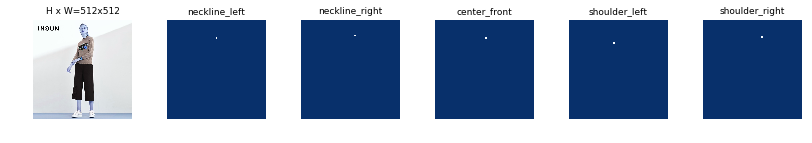

mask_shape: (511, 414, 4)
class_ids [16 17 18 19]
top_ids [16, 17, 18, 19]


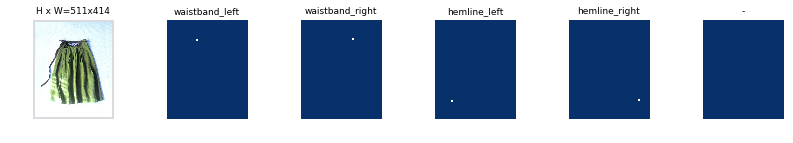

mask_shape: (512, 360, 7)
class_ids [16 17 20 21 22 23 24]
top_ids [16, 17, 20, 21, 22, 23, 24]


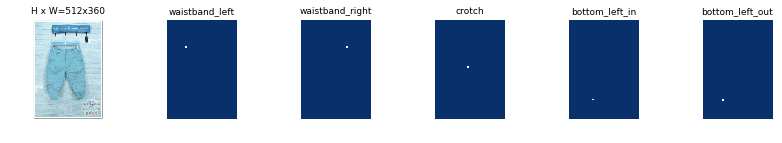

mask_shape: (512, 512, 12)
class_ids [ 1  2  4  5  6  7 10 11 12 13 14 15]
top_ids [1, 2, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15]


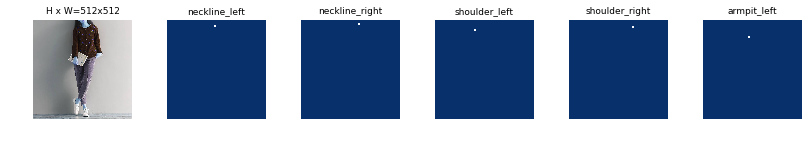

mask_shape: (512, 512, 13)
class_ids [ 1  2  3  4  5  6  7 10 11 12 13 14 15]
top_ids [1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15]


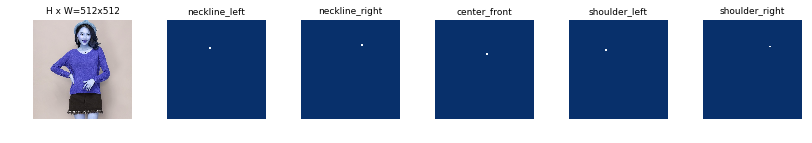

mask_shape: (512, 340, 4)
class_ids [16 17 18 19]
top_ids [16, 17, 18, 19]


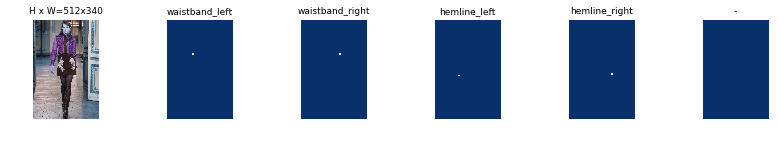

mask_shape: (512, 512, 4)
class_ids [16 17 18 19]
top_ids [16, 17, 18, 19]


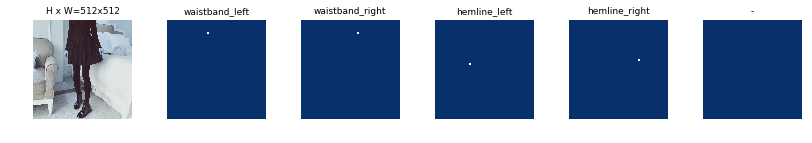

mask_shape: (512, 397, 13)
class_ids [ 1  2  3  4  5  6  7 10 11 12 13 14 15]
top_ids [1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15]


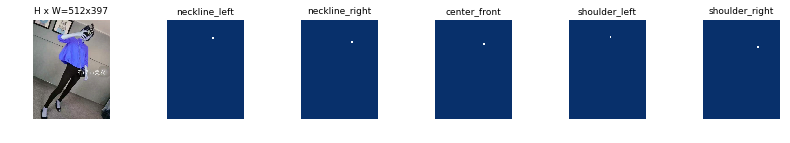

mask_shape: (512, 512, 15)
class_ids [ 1  2  3  4  5  6  7  8  9 10 11 12 13 18 19]
top_ids [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19]


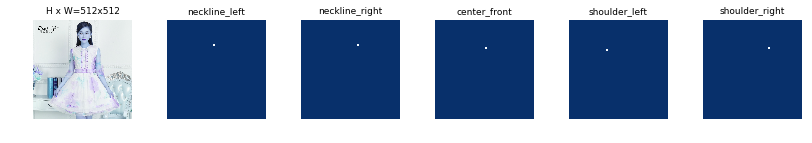

mask_shape: (512, 512, 7)
class_ids [16 17 20 21 22 23 24]
top_ids [16, 17, 20, 21, 22, 23, 24]


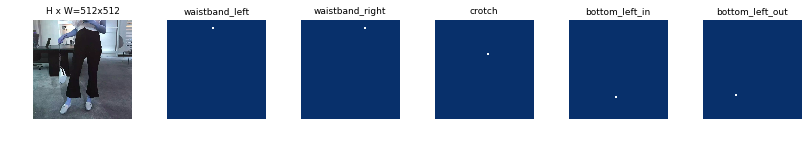

In [34]:
# Load and display random samples
np.random.seed(78)
image_ids = np.random.choice(dataset_train.image_ids, 10)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids,_ = dataset_train.load_mask(image_id)
    print('mask_shape:',mask.shape)
    print('class_ids',class_ids)
    display_top_masks(image, mask, class_ids, dataset_train.class_names)

image                    shape: (512, 409, 3)         min:    0.00000  max:  255.00000
mask                     shape: (512, 409, 13)        min:    0.00000  max:    1.00000
class_ids                shape: (13,)                 min:    1.00000  max:   19.00000
bbox                     shape: (13, 4)               min:   63.00000  max:  480.00000


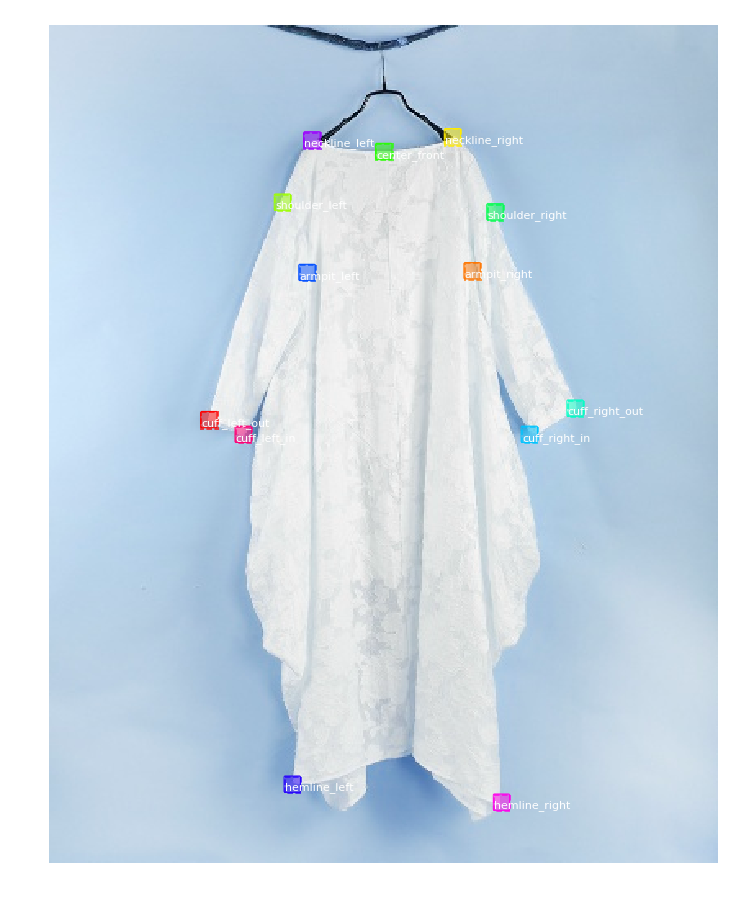

In [35]:
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids,_ = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
#print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

In [36]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [37]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [38]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/shenhuaifeng/Documents/Mask_RCNN-master/logs/fi20180318T1305/mask_rcnn_fi_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistrib

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
ERROR:root:Error processing image {'height': 512, 'source': 'FI', 'width': 512, 'path': './data/train/Images/trousers/a9561e54681d69f3c00714e9af90dd94.jpg', 'key_points': [[-1, -1, -1], [-1, -1, -1], [-1, -1, -1], [-1, -1, -1], [-1, -1, -1], [-1, -1, -1], [-1, -1, -1], [-1, -1, -1], [-1, -1, -1], [-1, -1, -1], [-1, -1, -1], [-1, -1, -1], [-1, -1, -1], [-1, -1, -1], [-1, -1, -1], [47, 100, 1], [482, 113, 1], [-1, -1

InvalidArgumentError: Incompatible shapes: [0,48,48] vs. [0,28,28]
	 [[Node: training/SGD/gradients/mrcnn_mask_loss_1/logistic_loss/mul_grad/BroadcastGradientArgs = BroadcastGradientArgs[T=DT_INT32, _class=["loc:@mrcnn_mask_loss_1/logistic_loss/mul"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](training/SGD/gradients/mrcnn_mask_loss_1/logistic_loss/mul_grad/Shape, training/SGD/gradients/mrcnn_mask_loss_1/logistic_loss/mul_grad/Shape_1)]]

Caused by op 'training/SGD/gradients/mrcnn_mask_loss_1/logistic_loss/mul_grad/BroadcastGradientArgs', defined at:
  File "/usr/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/lib/python3/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/lib/python3/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2793, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-2101606c7d8e>", line 8, in <module>
    layers='heads')
  File "/home/shenhuaifeng/Documents/Mask_RCNN-master/model.py", line 2238, in train
    use_multiprocessing=True,
  File "/usr/local/lib/python3.5/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/training.py", line 2080, in fit_generator
    self._make_train_function()
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "/usr/local/lib/python3.5/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/optimizers.py", line 173, in get_updates
    grads = self.get_gradients(loss, params)
  File "/usr/local/lib/python3.5/dist-packages/keras/optimizers.py", line 78, in get_gradients
    grads = K.gradients(loss, params)
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 2515, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py", line 611, in gradients
    lambda: grad_fn(op, *out_grads))
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py", line 377, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py", line 611, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py", line 793, in _MulGrad
    rx, ry = gen_array_ops._broadcast_gradient_args(sx, sy)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 461, in _broadcast_gradient_args
    "BroadcastGradientArgs", s0=s0, s1=s1, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'mrcnn_mask_loss_1/logistic_loss/mul', defined at:
  File "/usr/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 16 identical lines from previous traceback]
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-ae82d0e47c39>", line 3, in <module>
    model_dir=MODEL_DIR)
  File "/home/shenhuaifeng/Documents/Mask_RCNN-master/model.py", line 1763, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "/home/shenhuaifeng/Documents/Mask_RCNN-master/model.py", line 1929, in build
    [target_mask, target_class_ids, mrcnn_mask])
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/layers/core.py", line 663, in call
    return self.function(inputs, **arguments)
  File "/home/shenhuaifeng/Documents/Mask_RCNN-master/model.py", line 1928, in <lambda>
    mask_loss = KL.Lambda(lambda x: mrcnn_mask_loss_graph(*x), name="mrcnn_mask_loss")(
  File "/home/shenhuaifeng/Documents/Mask_RCNN-master/model.py", line 1157, in mrcnn_mask_loss_graph
    K.binary_crossentropy(target=y_true, output=y_pred),
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 3072, in binary_crossentropy
    logits=output)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_impl.py", line 181, in sigmoid_cross_entropy_with_logits
    relu_logits - logits * labels,
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_ops.py", line 934, in binary_op_wrapper
    return func(x, y, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_ops.py", line 1161, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 2789, in _mul
    "Mul", x=x, y=y, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [0,48,48] vs. [0,28,28]
	 [[Node: training/SGD/gradients/mrcnn_mask_loss_1/logistic_loss/mul_grad/BroadcastGradientArgs = BroadcastGradientArgs[T=DT_INT32, _class=["loc:@mrcnn_mask_loss_1/logistic_loss/mul"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](training/SGD/gradients/mrcnn_mask_loss_1/logistic_loss/mul_grad/Shape, training/SGD/gradients/mrcnn_mask_loss_1/logistic_loss/mul_grad/Shape_1)]]
